In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from scipy.signal import hamming

import librosa
import os
import math
import numpy as np
import csv
from scipy.signal import find_peaks

def nota_index_in_nota_octava(nota_index):
    note = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    nota = (nota_index - 1) % len(note)
    nota = note[nota]
    octava = (nota_index + 8) // len(note)

    return nota, octava


def frecv_in_nota_index(pitch):
    if not pitch:
        pitch += 1e-15

    nota_index = 12 * math.log2(pitch / 440) + 49
    offset_from_note = nota_index
    nota_index = round(nota_index)
    offset_from_note -= nota_index
    nota = nota_index_in_nota_octava(nota_index)

    return nota


def autocorelatie(y, sr=22050):
    corr = np.correlate(y, y, 'full')[len(y) - 1:]
    peaks, dics = find_peaks(corr, height=0)
    top = np.argsort(corr[peaks])[-2:]
    ind = top[-1]
    pitch = sr / peaks[ind]

    nota = frecv_in_nota_index(pitch)
    nota = ''.join(map(str, nota))

    return nota, pitch


def generare_onseturi(fisier_wav):
    y, sr = librosa.load(fisier_wav)
    print(sr)  #rata de esnationare
    print(len(y))  #y = duratata semnal in secunde * rata de esantionare sr
    #durata = len(y)/sr

    plt.figure(figsize=(14,5))
    librosa.display.waveshow(y, sr=sr)

    o_env = librosa.onset.onset_strength(y=y, sr=sr)
    times = librosa.times_like(o_env, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

    print(onset_frames) # frame numbers of estimated onsets

    onset_times = librosa.frames_to_time(onset_frames)
    print(onset_times)

    y_db = 10.0 * np.log10(y)

    plt.figure(figsize=(10,5))
    librosa.display.waveshow(y, sr=sr)
    plt.vlines(onset_times, -0.3, 0.3, color = 'r')
    
    return y, sr, onset_times
    
# cadre onset-uri
def autocorelatie_onseturi(fisier_wav, fisier_csv):
    y, sr, onset_times = generare_onseturi(fisier_wav)
    durata = len(y) / sr
    timpi = np.arange(0, durata, 1/sr)
    dictionar = {}
    nr_esantion = [i for i in range(1, len(y) + 1)]
    for i in range(len(nr_esantion)):
        dictionar[nr_esantion[i]] = timpi[i]

    cadre = []
    for i in range(len(onset_times)):
        onset1 = onset_times[i]
        try:
            onset2 = onset_times[i+1]
        except IndexError:
            onset2 = timpi[-1]
        cadru_curent = []
        for j in range(len(y)):
            if j in dictionar:
                if dictionar[j] > onset1: 
                    if dictionar[j] < onset2:
                        cadru_curent.append(j)
                    else:
                        break
        cadre.append(cadru_curent)

    # fiecare onset are o lista de esantioane
    esantioane_onset = []
    for i in range(len(cadre)):
        esantioane_onset.append(y[cadre[i][0] : cadre[i][-1]])

    # note aferente fiecarui onset  
    note = []
    frecvente = []
    for i in esantioane_onset:
        nota, pitch = autocorelatie(i)
#         print(nota, pitch)
        note.append(nota)
        frecvente.append(pitch)

    with open(fisier_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['pitch', 'nota'])
        randuri = []
        for i,j in zip(frecvente, note):
            randuri.append([i, j])
        writer.writerows(randuri)
        
    return 0


def antrenare(fisier_antrenare):
    df_train = pd.read_csv(fisier_antrenare)    
    nume_fisiere = df_train.iloc[:, 0].values
    frecvente = df_train.iloc[:, 1].values

    X_train = frecvente                            
    y_train = [nume_fisiere[i][:3] if nume_fisiere[i][2] == "#" else nume_fisiere[i][:2] for i in range(len(nume_fisiere))]

    model = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    X_train = X_train.reshape(-1,1)
    model.fit(X_train, y_train)
    joblib.dump(model, 'knn_model.joblib')
    
# Testare
def testare(fisier_csv):
    df_test = pd.read_csv(fisier_csv)
    frecvente = df_test.iloc[:, 0].values
    X_test = frecvente
    X_test = X_test.reshape(-1, 1)

    model = joblib.load('knn_model.joblib')
    predictii = model.predict(X_test)
        
    return predictii

22050
383260
[  7  18  30  42  54  66  77  90 102 112 124 136 152 169 195 208 219 230
 240 252 263 274 286 297 308 319 335 351 388 401 412 423 434 446 457 467
 477 487 497 512 527 549 561 571 581 593 604 615 626 637 648 659 686 707
 727]
[ 0.16253968  0.41795918  0.69659864  0.9752381   1.25387755  1.53251701
  1.78793651  2.08979592  2.36843537  2.60063492  2.87927438  3.15791383
  3.52943311  3.92417234  4.52789116  4.82975057  5.08517007  5.34058957
  5.57278912  5.85142857  6.10684807  6.36226757  6.64090703  6.89632653
  7.15174603  7.40716553  7.77868481  8.15020408  9.0093424   9.31120181
  9.56662132  9.82204082 10.07746032 10.35609977 10.61151927 10.84371882
 11.07591837 11.30811791 11.54031746 11.88861678 12.2369161  12.7477551
 13.02639456 13.2585941  13.49079365 13.76943311 14.02485261 14.28027211
 14.53569161 14.79111111 15.04653061 15.30195011 15.92888889 16.41650794
 16.88090703]


C:\Users\User\AppData\Local\Temp/ipykernel_24284/790685809.py:72: RuntimeWarning: invalid value encountered in log10
  y_db = 10.0 * np.log10(y)


['B3',
 'B3',
 'B3',
 'C4',
 'C4',
 'A3',
 'G3',
 'C4',
 'C4',
 'A3',
 'C3',
 'C4',
 'D4',
 'D4',
 'B3',
 'B3',
 'B3',
 'C4',
 'C4',
 'A3',
 'G3',
 'C4',
 'C4',
 'A3',
 'G3',
 'C3',
 'D4',
 'D4',
 'C4',
 'C3',
 'A3',
 'A4',
 'G4',
 'C3',
 'E4',
 'E4',
 'D4',
 'C4',
 'E4',
 'G4',
 'E3',
 'B3',
 'B3',
 'B3',
 'C4',
 'C4',
 'A3',
 'C3',
 'C4',
 'C4',
 'A3',
 'G3',
 'C3',
 'B3',
 'C4']

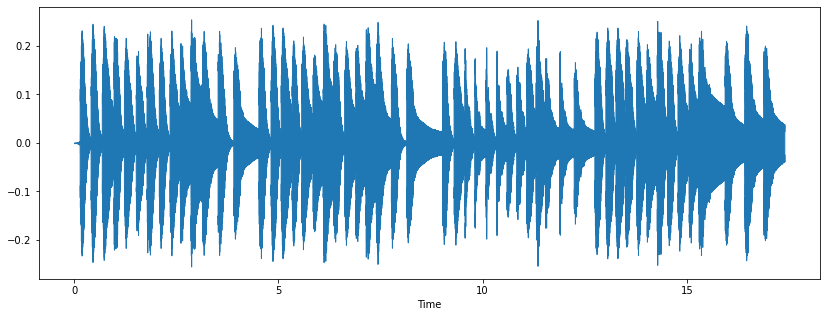

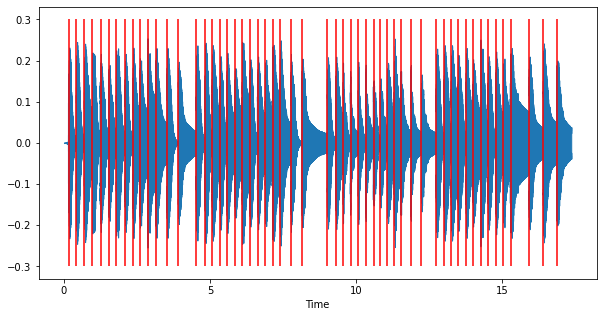

In [2]:
fisier_antrenare = 'autocor_train.csv'
fisier_wav = 'whistle3.wav'
fisier_csv = 'whistle3.csv'

antrenare(fisier_antrenare)

autocorelatie_onseturi(fisier_wav, fisier_csv)

predictii = testare(fisier_csv)
predictii = predictii.tolist()
predictii

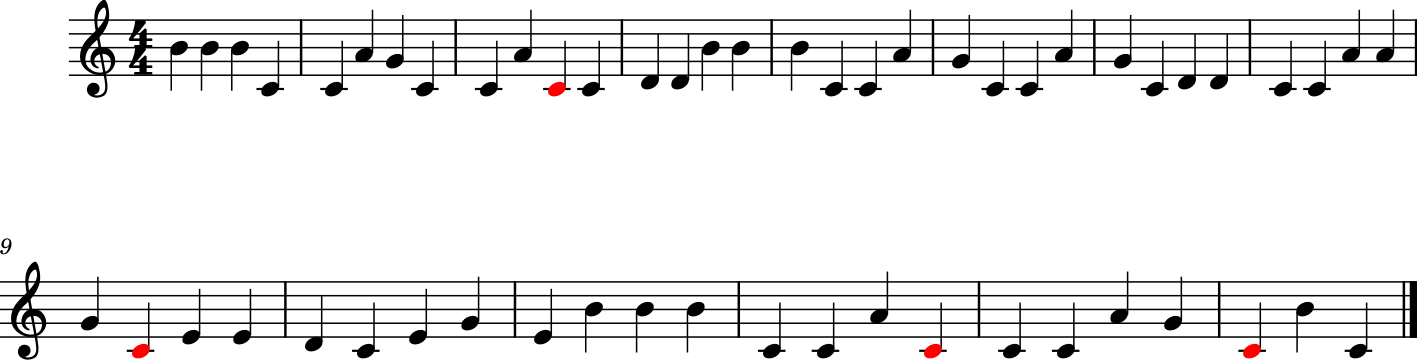

In [3]:
from music21 import *

note_prezise = predictii

note_corecte = ['B3','B3','B3','C4','C4','A3','G3','C4','C4','A3','G3','C4','D4','D4','B3','B3','B3','C4','C4','A3',
                      'G3','C4','C4','A3','G3','C4','D4','D4','C4','C4','A4','A4','G4','G4','E4','E4','D4','C4','E4','G4',
                      'E4','B3','B3','B3','C4','C4','A3','G3','C4','C4','A3','G3','D4','B3','C4']


s = stream.Stream()
for i, j in zip(note_prezise, note_corecte):
        if i[0] != j[0]:
            n = note.Note(i[0], quarterLength = 1)
            n.style.color='red'
            s.append([n])
        else:
            n = note.Note(i[0], quarterLength = 1)
            s.append([n])
    
s.show()

In [4]:
# old

In [5]:
# Testare
df_test = pd.read_csv('semnal_autocor_onseturi.csv')
frecvente = df_test.iloc[:, 0].values
X_test = frecvente
X_test = X_test.reshape(-1, 1)

model = joblib.load('knn_model.joblib')
predictii = model.predict(X_test)

for i,j in zip(X_test, predictii):
    print(i,j)

[132.03592814] C3
[147.98657718] D3
[165.78947368] E3
[175.] F3
[195.13274336] G3
[175.] F3
[165.78947368] E3
[147.98657718] D3
[132.03592814] C3


In [6]:
# Ferestre

df_test = pd.read_csv('semnal_autocor_ferestre.csv')
frecvente = df_test.iloc[:, 0].values
X_test = []
indecsi_newline = []
for i in range(len(frecvente)):
    if frecvente[i] == '\n':
        indecsi_newline.append(i)

onset1 = 0
for i in range(len(indecsi_newline)):
    onset2 = indecsi_newline[i]
    X_test.append(frecvente[onset1:onset2])
    onset1 = indecsi_newline[i] + 1

predictii = []
for i in range(len(X_test)):
    X_test_onset = X_test[i].reshape(-1, 1)
    predictie_onset = model.predict(X_test_onset)
    predictii.append(predictie_onset)
    
for i,j in zip(X_test, predictii):
    print('inceput onset')
    for x, y in zip(i,j):
        print(x, y)
    print('final onset\n')

In [7]:
frecvente

array(['262.5', '132.0359281', '132.0359281', '132.0359281',
       '132.0359281', '132.0359281', '132.0359281', '132.0359281',
       '132.0359281', '132.0359281', '132.0359281', '\r\n', '132.0359281',
       '132.0359281', '306.25', '146.0264901', '294', '147.9865772',
       '147.9865772', '294', '294', '147.9865772', '147.9865772',
       '147.9865772', '\r\n', '294', '147', '147.9865772', '147.9865772',
       '162.1323529', '329.1044776', '165.7894737', '167.0454545',
       '165.7894737', '165.7894737', '\r\n', '165.7894737', '165.7894737',
       '165.7894737', '165.7894737', '165.7894737', '165.7894737',
       '165.7894737', '165.7894737', '344.53125', '175', '175', '\r\n',
       '175', '175', '350', '176.4', '175', '175', '175', '175', '175',
       '175', '175', '180.7377049', '\r\n', '193.4210526', '193.4210526',
       '195.1327434', '195.1327434', '195.1327434', '195.1327434',
       '196.875', '195.1327434', '196.875', '195.1327434', '198.6486486',
       '\r\n', '196.

In [8]:
for i in range(len(predictii)):
    etichete, aparitii = np.unique(predictii[i], return_counts=True)
    print(etichete, aparitii)
    aparitie_max = np.amax(aparitii)
    index_aparitie_max = np.where(aparitii == aparitie_max)[0][0]
    eticheta_probabila = etichete[index_aparitie_max]
    print(eticheta_probabila)